In [94]:
import pandas as pd

train = pd.read_json('data/trainmodel.json')
validate = pd.read_json('data/val.json')

train['answers'] = train['answers'].apply(lambda x: x[0])
validate['answers'] = validate['answers'].apply(lambda x: x[0])

In [95]:
train.head(5)

,qId,answers,qText
0,wqr000001,Padmé Amidala,what character did natalie portman play in sta...
1,wqr000002,New York City,what state does selena gomez?
2,wqr000003,Bahamas,what country is the grand bahama island in?
3,wqr000005,Denethor II,what character did john noble play in lord of ...
4,wqr000006,Chicago Bulls,who does joakim noah play for?


In [96]:
questions = train['qText'].values
answers = train['answers'].values
questions_val = validate['qText'].values
answers_val = validate['answers'].values

questions_text = " ".join(list(questions))
answers_text = " ".join(list(answers))
questions_val_text = " ".join(list(questions_val))
answers_val_text = " ".join(list(answers_val))

full_text = questions_text + " " + answers_text

In [97]:
vocab_size = len(set(full_text))

encoder_map = {c: i for i, c in enumerate(set(full_text))}
decoder_map = {i: c for i, c in enumerate(set(full_text))}

encode = lambda x: [encoder_map[c] for c in x]
decode = lambda x: ''.join([decoder_map[i] for i in x])


In [98]:
encode("Test string"), decode(encode("Test string"))

([52, 24, 86, 54, 47, 86, 54, 55, 34, 56, 5], 'Test string')

In [99]:
import torch

torch.manual_seed(2115)
batch_size = 16
seq_len = 64
n_embed = 32
num_heads = 8


def pad_sequences(sequences, seq_len):
    padded_sequences = [seq + [0] * (seq_len - len(seq)) for seq in sequences]
    return padded_sequences


def truncate_sequences(sequences, max_len):
    truncated_sequences = [seq[:max_len] for seq in sequences]
    return truncated_sequences


def get_batches(questions, answers):
    idx = torch.randint(0, len(questions), (batch_size,))
    batch_questions = questions[idx].tolist()
    batch_answers = answers[idx].tolist()

    encoded_questions = [encode(q)[:-1] for q in batch_questions]
    encoded_answers = [encode(a)[:-1] for a in batch_answers]

    y_questions = [encode(q)[1:] for q in batch_questions]
    y_answers = [encode(a)[1:] for a in batch_answers]

    encoded_questions = truncate_sequences(encoded_questions, seq_len)
    encoded_answers = truncate_sequences(encoded_answers, seq_len)
    y_questions = truncate_sequences(y_questions, seq_len)
    y_answers = truncate_sequences(y_answers, seq_len)

    x = pad_sequences(encoded_questions, seq_len)
    y = pad_sequences(y_questions, seq_len)
    x_ans = pad_sequences(encoded_answers, seq_len)
    y_ans = pad_sequences(y_answers, seq_len)

    x, y, x_ans, y_ans = map(lambda seqs: torch.tensor(seqs), [x, y, x_ans, y_ans])

    return x, y, x_ans, y_ans


x, y, x_ans, y_ans = get_batches(questions, answers)

In [100]:
import torch.nn as nn
from torch.nn import functional as F


class MaskedHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(seq_len, seq_len)))
        self.head_size = head_size
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        weights = q @ k.transpose(-1, -2) * C ** -0.5
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)
        return weights @ v


class HeadEncoder(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.head_size = head_size
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        weights = q @ k.transpose(-1, -2) * C ** -0.5
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)
        return weights @ v


class HeadDecoder(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.head_size = head_size
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, k, v):
        B, T, C = x.shape
        q = self.query(x)
        weights = q @ k.transpose(-1, -2) * C ** -0.5
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)
        return weights @ v

In [101]:
class MaskedMultiHead(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))


class MultiHeadEncoder(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([HeadEncoder(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))


class MultiHeadDecoder(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([HeadDecoder(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, k, v):
        out = torch.cat([h(x, k, v) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))

In [102]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 4 * hidden_size),
            nn.ReLU(),
            nn.Linear(4 * hidden_size, hidden_size),
            nn.Dropout(0.1),
        )

    def forward(self, x):
        return self.net(x)

In [103]:
class BlockDecoder(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.msa_heads = MaskedMultiHead(n_head, head_size)
        self.sa_heads = MultiHeadDecoder(n_head, head_size)
        self.feed_forward = FeedForward(n_embed)
        self.layer_norm1 = nn.LayerNorm(n_embed)
        self.layer_norm2 = nn.LayerNorm(n_embed)
        self.layer_norm3 = nn.LayerNorm(n_embed)

    def forward(self, x, k, v):
        x = x + self.msa_heads(self.layer_norm1(x))
        x = x + self.sa_heads(self.layer_norm2(x), k, v)
        x = x + self.feed_forward(self.layer_norm3(x))
        return x


class BlockEncoder(nn.Module):
    def __init__(self, n_embed, n_head, head_size):
        super().__init__()
        self.sa_heads = MultiHeadEncoder(n_head, head_size)
        self.feed_forward = FeedForward(n_embed)
        self.layer_norm1 = nn.LayerNorm(n_embed)
        self.layer_norm2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa_heads(self.layer_norm1(x))
        x = x + self.feed_forward(self.layer_norm2(x))
        return x

In [104]:
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(seq_len, n_embed)
        self.blocks = [BlockDecoder(n_embed, num_heads) for _ in range(3)]
        self.blocks = nn.ModuleList(self.blocks)
        self.layer_norm = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, k, v, targets=None):
        B, T = idx.shape
        token_embedding = self.token_embedding_table(idx)
        position_embedding = self.position_embedding_table(torch.arange(T))
        x = token_embedding + position_embedding
        for block in self.blocks:
            x = block(x, k, v)
        x = self.layer_norm(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, n):
        for _ in range(n):
            idx_crop = idx[:, -seq_len:]
            logits, _ = self(idx_crop)
            logits = logits[:, -1, :]
            p = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(p, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx

In [105]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        head_size = n_embed // num_heads
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(seq_len, n_embed)
        self.blocks = nn.Sequential(*[BlockEncoder(n_embed, num_heads, head_size) for _ in range(2)])
        self.layer_norm = nn.LayerNorm(n_embed)
        self.key_projection = nn.Linear(n_embed, head_size)
        self.value_projection = nn.Linear(n_embed, head_size)

    def forward(self, idx):
        B, T = idx.shape
        token_embedding = self.token_embedding_table(idx)
        position_embedding = self.position_embedding_table(torch.arange(T))
        x = token_embedding + position_embedding
        x = self.blocks(x)
        x = self.layer_norm(x)
        k = self.key_projection(x)
        v = self.value_projection(x)
        return k, v

In [106]:
class EncoderDecoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, prompt, response, targets=None):
        k, v = self.encoder(prompt)

        x, loss = self.decoder(response, k, v, targets)
        return x, loss

    def generate(self, prompt, idx, n):
        for _ in range(n):
            idx_crop = idx[:, -seq_len:]
            logits, _ = self(idx_crop, prompt)
            logits = logits[:, -1, :]
            p = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(p, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx

In [107]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y, x_ans, y_ans = get_batches(questions, answers) if split == 'train' else get_batches(questions_val, answers_val)
            logits, loss = model(x, y, x_ans)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [108]:
import os


def notify_end_of_cell(message="Cell execution completed!"):
    os.system(f'notify-send "Jupyter Cell Notification" "{message}"')

In [109]:
m = EncoderDecoder()

In [110]:
optimizer = torch.optim.Adam(m.parameters(), lr=0.0003)

history = []
eval_interval = 5
max_iter = 1000
for iter in range(max_iter):
    if iter % eval_interval == 0:
        losses = estimate_loss(m)
        history.append((iter, losses))
        print(f'Iter {iter}, train loss: {losses["train"]:.3f}, val loss: {losses["val"]:.3f}')

    x, y, x_ans, y_ans = get_batches(questions, answers)
    logits, loss = m(x, y, x_ans)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
notify_end_of_cell()

Iter 0, train loss: 4.723, val loss: 4.720
Iter 5, train loss: 4.225, val loss: 4.234
Iter 10, train loss: 3.773, val loss: 3.799
Iter 15, train loss: 3.379, val loss: 3.413
Iter 20, train loss: 3.038, val loss: 3.064
Iter 25, train loss: 2.761, val loss: 2.803
Iter 30, train loss: 2.559, val loss: 2.606
Iter 35, train loss: 2.402, val loss: 2.435
Iter 40, train loss: 2.267, val loss: 2.310
Iter 45, train loss: 2.167, val loss: 2.208
Iter 50, train loss: 2.082, val loss: 2.141
Iter 55, train loss: 1.997, val loss: 2.064
Iter 60, train loss: 1.927, val loss: 1.966
Iter 65, train loss: 1.873, val loss: 1.912
Iter 70, train loss: 1.811, val loss: 1.866
Iter 75, train loss: 1.777, val loss: 1.827
Iter 80, train loss: 1.732, val loss: 1.776
Iter 85, train loss: 1.672, val loss: 1.734
Iter 90, train loss: 1.622, val loss: 1.673
Iter 95, train loss: 1.603, val loss: 1.683
Iter 100, train loss: 1.576, val loss: 1.640
Iter 105, train loss: 1.543, val loss: 1.591
Iter 110, train loss: 1.524, val

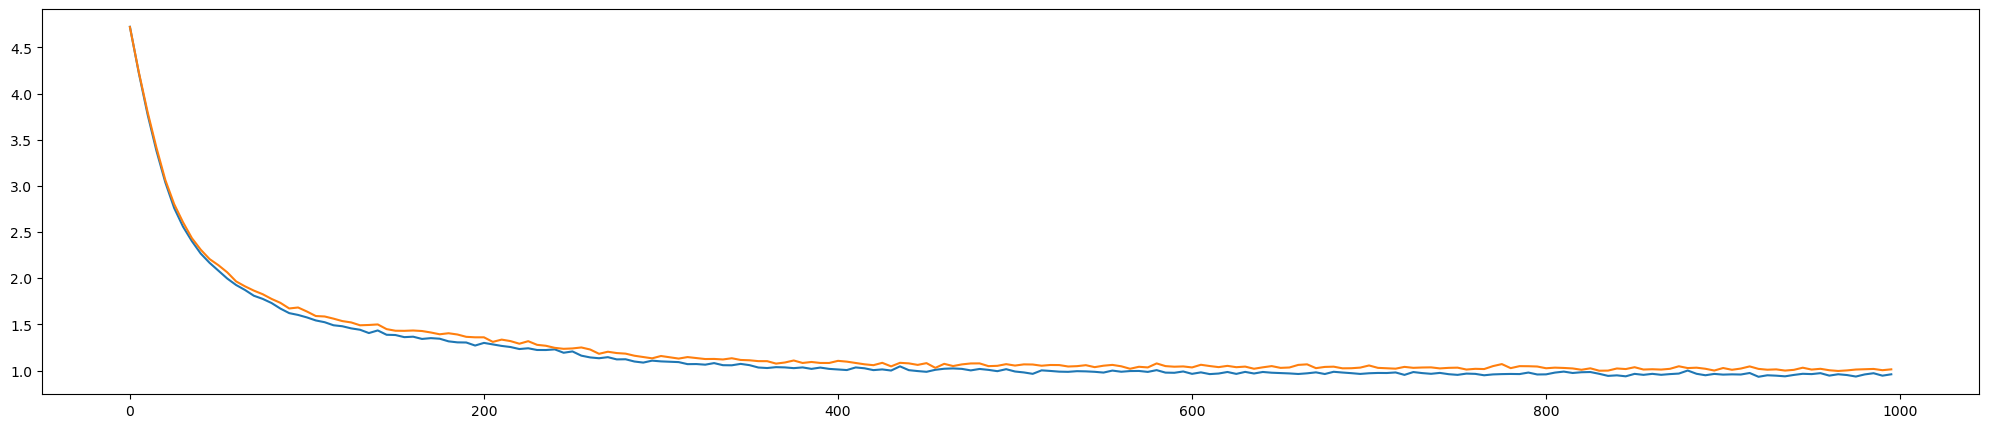

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 5))

x = [h[0] for h in history]
y = [h[1]['train'] for h in history]
y_val = [h[1]['val'] for h in history]
plt.plot(x, y, label='train')
plt.plot(x, y_val, label='val')

In [112]:
prompt = 'What is the capital of France?'
prompt = torch.tensor(truncate_sequences([encode(prompt)], seq_len))
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(m.generate(prompt, idx, 1000)[0].tolist()))

ccccccccccccccccccccccccccccccccccccccnccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccsccccccccciccccccccccccccccccccccc ccccccccccccccccccccccccccccccccccccccccccccccccäccfccccccccdcccciccccccccccccccccccccccccccccccccccsccccccaccccccccccccccclcccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccnclccccccccAccccccccccccccccccccccccccccccccc/cccccccccccccccccccclciccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccÉcccccccccccccccccccccccccccccccchccccccccccccccccccccccccccccccccmccctcccccccccccchccccccccccccccccccccccccccccccccccccccccccccccccccccccrcccccccccccccccccccacccnucccccccccccccccccccccccccccccccccccccccccccc cccccctccccccccccccccccccccccccccc crccccccncc3cccccccccccccäcccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccceccccfcccccccccccccccccccccccccccccccccccccccccccccccccccccpcccccccccccccccccccc

In [113]:
torch.save(m.state_dict(), './models/parallel_checkpoints_64_2.pth')